# Reducers

## Introduction
In this Jupyter Notebook we determine the best temporal reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiment involves processing the satellite imagery using the Google Earth Engine (GEE). Please refer to the README file in this repository for a tutorial on how to set up GEE.

## Ground Truth Label

The ground truth label is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31). Alternatively you can use the processed GeoTIFF raster "data/processed/y.tif" for the leaf type mixture label. The raster "data/processed/y_area.tif" contains the base area per leaf type.

The next cells load the dataset and analyze it.

In [1]:
# Load the data and convert it to a GeoDataFrame
import pandas as pd
import geopandas as gpd

df = pd.read_csv("../data/interim/plot.csv", parse_dates=["date"])

data = df.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

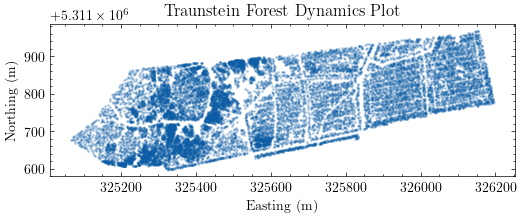

In [2]:
# Plot the data on stem level
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

ax = gdf.plot(markersize=1, figsize=(6, 2), alpha=0.25)
ax.set_title("Traunstein Forest Dynamics Plot")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.show()

First sample: 2015-03-11
Last sample: 2016-04-13


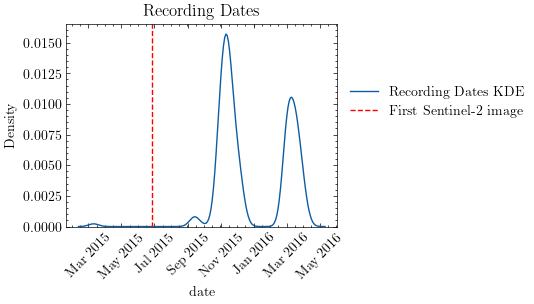

In [3]:
# Plot the distribution of the recording dates
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

print(f"First sample: {gdf['date'].min().strftime('%Y-%m-%d')}")
print(f"Last sample: {gdf['date'].max().strftime('%Y-%m-%d')}")

ax = sns.kdeplot(gdf["date"], label="Recording Dates KDE")
ax.set_title("Recording Dates")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.axvline(datetime(2015, 6, 27), linestyle="--", color="red", label="First Sentinel-2 image")

golden_ratio = (1 + 5 ** 0.5) / 2
ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 1/golden_ratio),
)

plt.show()

In [4]:
# Convert the data to two rasters
from ltm.data import compute_label
from pathlib import Path

y_path = "../data/processed/y.tif"
y_area_path = "../data/processed/y_area.tif"

if not Path(y_path).exists():
    compute_label(y_path=y_path, plot=df)

if not Path(y_area_path).exists():
    compute_label(y_path=y_area_path, plot=df, area_as_y=True)

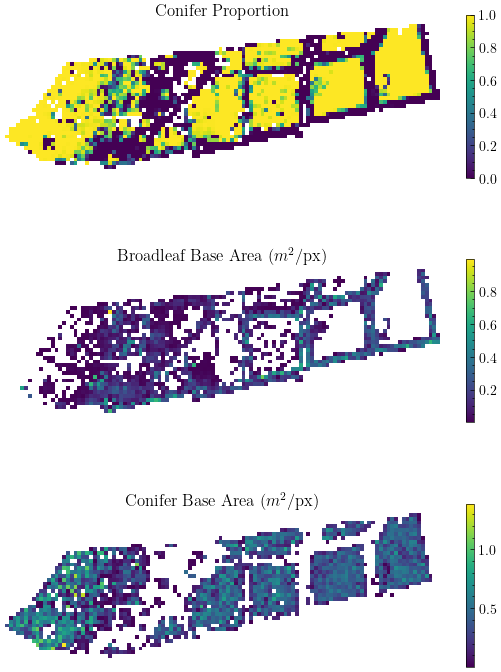

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import rasterio
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

with rasterio.open("../data/processed/y.tif") as src:
    # Plot the broadleaf content
    y = src.read(1)

    img = axes[0].imshow(y, cmap="viridis", interpolation="nearest")
    axes[0].set_title("Conifer Proportion")
    axes[0].axis("off")

    fig.colorbar(img, shrink=0.8)

with rasterio.open("../data/processed/y_area.tif") as src:
    # Plot the broadleaf area
    broadleaf_area = src.read(1)
    broadleaf_area[broadleaf_area == 0] = np.nan

    img = axes[1].imshow(broadleaf_area, cmap="viridis", interpolation="nearest")
    axes[1].set_title("Broadleaf Base Area ($m^2$/px)")
    axes[1].axis("off")

    fig.colorbar(img, shrink=0.8)

    # Plot the conifer area
    conifer_area = src.read(2)
    conifer_area[conifer_area == 0] = np.nan

    img = axes[2].imshow(conifer_area, cmap="viridis", interpolation="nearest")
    axes[2].set_title("Conifer Base Area ($m^2$/px)")
    axes[2].axis("off")

    fig.colorbar(img, shrink=0.8)

plt.show()

## Experiment Details
The goal the first experiment is to find the temporal reducers that lead to the best performance in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. July, 2015. This covers all seasons as well as most recording dates.
- Level-1C Sentinel 2 satellite imagery is used, as Level-2A is available only from 2017 onwards.
- Random Forest with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on the following temporal reducers:

In [6]:
from ltm.data import list_reducers

list_reducers()

['And',
 'Or',
 'allNonZero',
 'anyNonZero',
 'circularMean',
 'circularStddev',
 'circularVariance',
 'count',
 'countDistinct',
 'countDistinctNonNull',
 'countRuns',
 'first',
 'firstNonNull',
 'kendallsCorrelation',
 'kurtosis',
 'last',
 'lastNonNull',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'product',
 'sampleStdDev',
 'sampleVariance',
 'skew',
 'stdDev',
 'sum',
 'variance']

In [7]:
from ltm.data import sentinel_composite, list_reducers, list_bands
from datetime import datetime

reducers = list_reducers()
sentinel_bands = [band for band in list_bands() if band.startswith("B")]

sentinel_composite(
    y_path_from="../data/processed/y.tif",
    X_path_to="../data/processed/X.tif",
    time_window=(datetime(2015, 7, 1), datetime(2016, 6, 30)),
    level_2a=False,
    temporal_reducers=reducers,
    sentinel_bands=sentinel_bands,
)

Initializing Earth Engine API...
Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/X.tif


'../data/processed/X.tif'

In [8]:
import rasterio

# extract band names
with rasterio.open("../data/processed/X.tif") as src:
    band_names = src.descriptions

band_names

('1 And B1',
 '1 And B2',
 '1 And B3',
 '1 And B4',
 '1 And B5',
 '1 And B6',
 '1 And B7',
 '1 And B8',
 '1 And B8A',
 '1 And B9',
 '1 And B11',
 '1 And B12',
 '1 Or B1',
 '1 Or B2',
 '1 Or B3',
 '1 Or B4',
 '1 Or B5',
 '1 Or B6',
 '1 Or B7',
 '1 Or B8',
 '1 Or B8A',
 '1 Or B9',
 '1 Or B11',
 '1 Or B12',
 '1 AllNonZero B1',
 '1 AllNonZero B2',
 '1 AllNonZero B3',
 '1 AllNonZero B4',
 '1 AllNonZero B5',
 '1 AllNonZero B6',
 '1 AllNonZero B7',
 '1 AllNonZero B8',
 '1 AllNonZero B8A',
 '1 AllNonZero B9',
 '1 AllNonZero B11',
 '1 AllNonZero B12',
 '1 AnyNonZero B1',
 '1 AnyNonZero B2',
 '1 AnyNonZero B3',
 '1 AnyNonZero B4',
 '1 AnyNonZero B5',
 '1 AnyNonZero B6',
 '1 AnyNonZero B7',
 '1 AnyNonZero B8',
 '1 AnyNonZero B8A',
 '1 AnyNonZero B9',
 '1 AnyNonZero B11',
 '1 AnyNonZero B12',
 '1 CircularMean B1',
 '1 CircularMean B2',
 '1 CircularMean B3',
 '1 CircularMean B4',
 '1 CircularMean B5',
 '1 CircularMean B6',
 '1 CircularMean B7',
 '1 CircularMean B8',
 '1 CircularMean B8A',
 '1 Circu